In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
import math

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
class Obj:
    pass

In [5]:
params = Obj()
params.input_dim = 784
params.n_l1 = 1000
params.n_l2 = 1000
params.z_dim = 2
params.batch_size = 100
params.n_epochs = 1000
params.learning_rate = 0.001
params.beta1 = 0.9

In [6]:
results_path = './Results/Autoencoder'

In [7]:
def dense(x, n1, n2, name):
    """
    Used to create a dense layer.
    :param x: input tensor to the dense layer
    :param n1: no. of input neurons
    :param n2: no. of output neurons
    :param name: name of the entire dense layer.i.e, variable scope name.
    :return: tensor with shape [batch_size, n2]
    """
    with tf.variable_scope(name, reuse=None):
        xav_stddev = np.sqrt(2 / (n1 + n2))
        weights = tf.get_variable("weights", shape=[n1, n2],
                                  initializer=tf.random_normal_initializer(mean=0., stddev=xav_stddev))
        bias = tf.get_variable("bias", shape=[n2], initializer=tf.constant_initializer(0.0))
        matmul = tf.add(tf.matmul(x, weights), bias, name='matmul')
    return matmul

In [8]:
def encoder(x, params, reuse=False):
    """
    Encode part of the autoencoder
    :param x: input to the autoencoder
    :param reuse: True -> Reuse the encoder variables, False -> Create or search of variables before creating
    :return: tensor which is the hidden latent variable of the autoencoder.
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Encoder'):
        e_dense_1 = tf.nn.relu(dense(x, params.input_dim, params.n_l1, 'e_dense_1'))
        e_dense_2 = tf.nn.relu(dense(e_dense_1, params.n_l1, params.n_l2, 'e_dense_2'))
        e_latent_variable = dense(e_dense_2, params.n_l2, params.z_dim, 'e_latent_variable')
    return e_latent_variable

In [9]:
def decoder(x, params, reuse=False):
    """
    Decoder part of the autoencoder
    :param x: input to the decoder
    :param reuse: True -> Reuse the decoder variables, False -> Create or search of variables before creating
    :return: tensor which should ideally be the input given to the encoder.
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Decoder'):
        d_dense_1 = tf.nn.relu(dense(x, params.z_dim, params.n_l2, 'd_dense_1'))
        d_dense_2 = tf.nn.relu(dense(d_dense_1, params.n_l2, params.n_l1, 'd_dense_2'))
        #output = tf.nn.sigmoid(dense(d_dense_2, params.n_l1, params.input_dim, 'd_output'))
        d_output = dense(d_dense_2, params.n_l1, params.input_dim, 'd_output')
        return d_output

In [10]:
def discriminator(x, params, reuse=False):
    """
    Discriminator that is used to match the posterior distribution with a given prior distribution.
    :param x: tensor of shape [batch_size, z_dim]
    :param reuse: True -> Reuse the discriminator variables,
                  False -> Create or search of variables before creating
    :return: tensor of shape [batch_size, 1]
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Discriminator'):
        dc_dense_1 = tf.nn.relu(dense(x, params.z_dim, params.n_l1, name='dc_dense_1'))
        dc_dense_2 = tf.nn.relu(dense(dc_dense_1, params.n_l1, params.n_l2, name='dc_dense_2'))
        dc_output = dense(dc_dense_2, params.n_l2, 1, name='dc_output')
    return dc_output

In [11]:
x_input = tf.placeholder(dtype=tf.float32, shape=[params.batch_size, params.input_dim], name='Input')
x_target = tf.placeholder(dtype=tf.float32, shape=[params.batch_size, params.input_dim], name='Target')
real_distribution = tf.placeholder(dtype=tf.float32, shape=[params.batch_size, params.z_dim], name='Real_distribution')
decoder_input = tf.placeholder(dtype=tf.float32, shape=[1, params.z_dim], name='Decoder_input')

In [12]:
with tf.variable_scope(tf.get_variable_scope()):
    encoder_output = encoder(x_input, params)
    decoder_output = decoder(encoder_output, params)

In [13]:
with tf.variable_scope(tf.get_variable_scope()):
    d_real = discriminator(real_distribution, params)
    d_fake = discriminator(encoder_output, params, reuse=True)

In [14]:
with tf.variable_scope(tf.get_variable_scope()):
    decoder_image = decoder(decoder_input, params, reuse=True)

In [15]:
# Losses
#loss = tf.reduce_mean(tf.square(x_target - decoder_output))
autoencoder_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=decoder_output, labels=x_target)) #, reduction_indices=1)
# Discriminator Loss
dc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_real), logits=d_real))
dc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_fake), logits=d_fake))
dc_loss = dc_loss_fake + dc_loss_real
# Generator loss
generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_fake), logits=d_fake))

In [16]:
all_variables = tf.trainable_variables()
dc_var = [var for var in all_variables if 'dc_' in var.name]
en_var = [var for var in all_variables if 'e_' in var.name]

In [17]:
# Optimizer
autoencoder_optimizer = tf.train.AdamOptimizer(learning_rate=params.learning_rate,
                                                   beta1=params.beta1).minimize(autoencoder_loss)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=params.learning_rate,
                                                     beta1=params.beta1).minimize(dc_loss, var_list=dc_var)
generator_optimizer = tf.train.AdamOptimizer(learning_rate=params.learning_rate, 
                                                 beta1=params.beta1).minimize(generator_loss, var_list=en_var)


In [18]:
# Evaluaton
gen_accuracy = tf.sqrt(tf.reduce_mean(tf.square(x_target - tf.nn.sigmoid(decoder_output))))

In [19]:
sess = tf.InteractiveSession()

In [20]:
turn = 1
if turn ==1:
    sess.run(tf.global_variables_initializer())

In [21]:
saver = tf.train.Saver()

In [22]:
mem = Obj()
mem.num_epoch = []
mem.encoder_eval = []
mem.dc_eval = []
mem.gen_eval =  []

for num_epoch in range (params.n_epochs):
    z_real_dist = np.random.randn(params.batch_size, params.z_dim) #* 5.
    
    if num_epoch % 10 == 0:
        batch_x, _ = mnist.train.next_batch(params.batch_size)
        mem.num_epoch += [num_epoch]
        encoder_eval = gen_accuracy.eval(feed_dict={x_input: batch_x, x_target: batch_x})
        dc_eval = dc_loss.eval(feed_dict={x_input: batch_x, real_distribution: z_real_dist})
        gen_eval = generator_loss.eval(feed_dict={x_input: batch_x})
        sys.stdout.write('\rstep %d\t reconstruction : %.5f\t discriminator : %.5f\t generator : %.5f' % (num_epoch, \
                                                                                                          encoder_eval, \
                                                                                                          dc_eval, \
                                                                                                          gen_eval))
        mem.encoder_eval += [encoder_eval]
        mem.dc_eval += [dc_eval]
        mem.gen_eval += [gen_eval]
        
    batch_x, _ = mnist.train.next_batch(params.batch_size)
    autoencoder_optimizer.run(feed_dict={x_input: batch_x, x_target: batch_x})
    
    batch_x, _ = mnist.train.next_batch(params.batch_size)
    discriminator_optimizer.run(feed_dict={x_input: batch_x, real_distribution: z_real_dist})
    
    batch_x, _ = mnist.train.next_batch(params.batch_size)
    generator_optimizer.run(feed_dict={x_input: batch_x})
    

step 990	 reconstruction : 0.22440	 discriminator : 1.38927	 generator : 0.67107

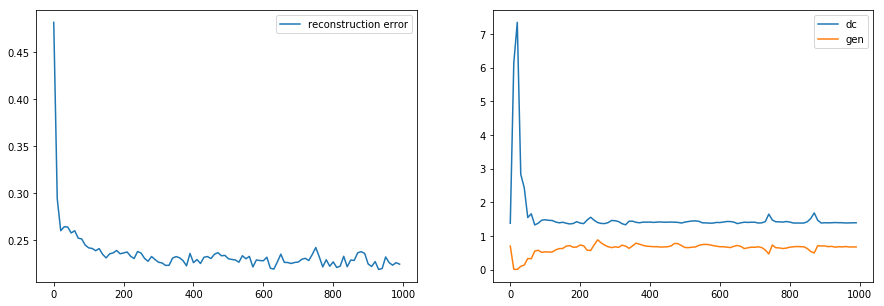

In [33]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(mem.num_epoch, mem.encoder_eval)
plt.legend(('reconstruction error',))
plt.subplot(1,2,2)
plt.plot(mem.num_epoch, mem.dc_eval)
plt.plot(mem.num_epoch, mem.gen_eval)
plt.legend(('dc','gen'))

In [34]:
x_test = mnist.test.next_batch(params.batch_size)
print(gen_accuracy.eval(feed_dict={x_input: batch_x, x_target: batch_x}))

0.218724


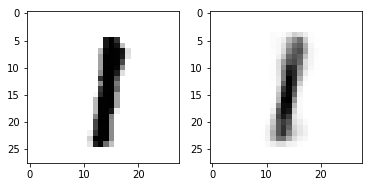

In [36]:
x_out = tf.nn.sigmoid(decoder_output).eval(feed_dict={x_input: batch_x})
i = 2
plt.subplot(1,2,1)
plt.imshow(batch_x[i].reshape((28, 28)), cmap = 'gray_r')
plt.subplot(1,2,2)
plt.imshow(x_out[i].reshape((28, 28)), cmap = 'gray_r')


In [37]:
#x_image = tf.nn.sigmoid(decoder_image).eval(feed_dict={decoder_input : np.zeros((1,params.z_dim))})


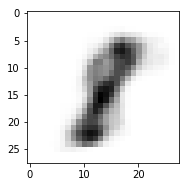

In [38]:
x_image = tf.nn.sigmoid(decoder_image).eval(feed_dict={decoder_input : np.random.randn((params.z_dim)).reshape((1, params.z_dim))})
plt.subplot(1,2,2)
plt.imshow(x_image.reshape((28, 28)), cmap = 'gray_r')

In [43]:
batch_x, batch_y = mnist.train.next_batch(params.batch_size)
liste_z = encoder_output.eval(feed_dict={x_input: batch_x})

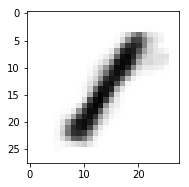

In [44]:
i = 2
x_image = tf.nn.sigmoid(decoder_image).eval(feed_dict={decoder_input : liste_z[i].reshape((1, params.z_dim))})
plt.subplot(1,2,1)
plt.imshow(x_image.reshape((28, 28)), cmap = 'gray_r')

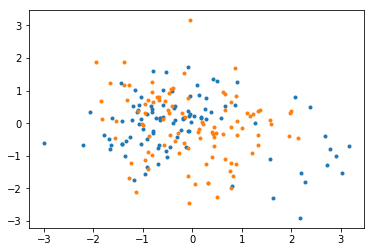

In [45]:
plt.plot(liste_z[:,0], liste_z[:,1], '.')
plt.plot(z_real_dist[:,0], z_real_dist[:,1], '.')

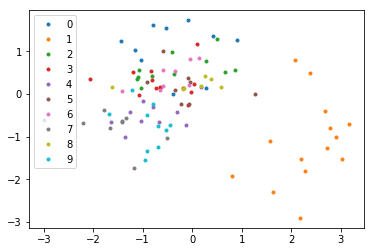

In [47]:
z_cat = {}
for i in range(10):
    z_cat[i] = []
for i in range(len(liste_z)):
    index = np.where(batch_y[i] == 1)[0][0]
    z_cat[index] += [liste_z[i]]
for i in range(10):
    z_aff = np.transpose(z_cat[i])
    plt.plot(z_aff[0,:], z_aff[1,:], '.')
plt.legend((0,1,2,3,4,5,6,7,8,9))